In [4]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import requests
import numpy as np, pandas as pd
import seaborn as sns

In [9]:
pages = np.arange(1, 10, 1) 
headers = {'Accept-Language': 'en-US,en;q=0.8'} 

#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

for page in pages:
  
   #get request for sci-fi
   response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                  + "start="
                  + str(page)
                  + "&explore=title_type,genres&ref_=adv_prv", headers=headers)
  
   sleep(randint(8,15))
   
   #throw warning for status codes that are not 200
   if response.status_code != 200:
       warn('Request: {}; Status code: {}'.format(requests, response.status_code))

   #parse the content of current iteration of request
   page_html = BeautifulSoup(response.text, 'html.parser')
      
   movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
  
   #extract the 50 movies for that page
   for container in movie_containers:

       #conditional for all with metascore
       if container.find('div', class_ = 'ratings-metascore') is not None:

           #title
           title = container.h3.a.text
           titles.append(title)

           if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
            
             #year released
             year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
             years.append(year)

           else:
             years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

           if container.p.find('span', class_ = 'certificate') is not None:
            
             #rating
             rating = container.p.find('span', class_= 'certificate').text
             ratings.append(rating)

           else:
             ratings.append("")

           if container.p.find('span', class_ = 'genre') is not None:
            
             #genre
             genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
             genres.append(genre)
          
           else:
             genres.append("")

           if container.p.find('span', class_ = 'runtime') is not None:

             #runtime
             time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
             runtimes.append(time)

           else:
             runtimes.append(None)

           if float(container.strong.text) is not None:

             #IMDB ratings
             imdb = float(container.strong.text) # non-standardized variable
             imdb_ratings.append(imdb)

           else:
             imdb_ratings.append(None)

           if container.find('span', class_ = 'metascore').text is not None:

             #Metascore
             m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
             metascores.append(m_score)

           else:
             metascores.append(None)

           if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

             #Number of votes
             vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
             votes.append(vote)

           else:
               votes.append(None)

In [10]:
sci_fi_df = pd.DataFrame({'movie': titles,
                      'year': years,
                      'rating': ratings,
                      'genre': genres,
                      'runtime_min': runtimes,
                      'imdb': imdb_ratings,
                      'metascore': metascores,
                      'votes': votes}
                      )

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1] # two more data transformations after scraping
# Drop 'ovie' bug
# Make year an int
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie'] # One small issue with the scrape on these two movies so just dropping those ones.
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

In [13]:
final_df

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
0,Avatar: The Way of Water,2022,PG-13,"[Action, Adventure, Fantasy]",192,7.9,67,239525,79.0
1,M3GAN,2022,PG-13,"[Horror, Sci-Fi, Thriller]",102,6.7,72,18110,67.0
2,Everything Everywhere All at Once,2022,R,"[Action, Adventure, Comedy]",139,8.0,81,287620,80.0
3,Avatar,2009,PG-13,"[Action, Adventure, Fantasy]",162,7.9,83,1304543,79.0
4,Jurassic World: Dominion,2022,PG-13,"[Action, Adventure, Sci-Fi]",147,5.6,38,162925,56.0
...,...,...,...,...,...,...,...,...,...
143,Inception,2010,PG-13,"[Action, Adventure, Sci-Fi]",148,8.8,74,2359918,88.0
144,Blade Runner 2049,2017,R,"[Action, Drama, Mystery]",164,8.0,81,580290,80.0
145,Jurassic Park,1993,PG-13,"[Action, Adventure, Sci-Fi]",127,8.2,68,993046,82.0
146,Mad Max: Fury Road,2015,R,"[Action, Adventure, Sci-Fi]",120,8.1,90,1007620,81.0


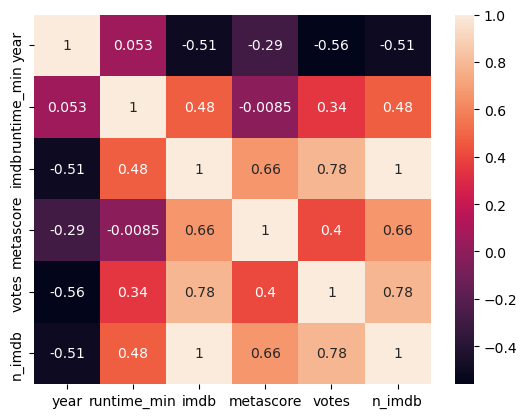

In [16]:
sns.heatmap(final_df.corr(), annot=True);